In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os

# **Data Preperation**

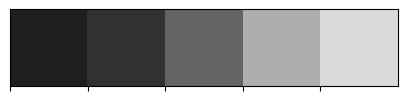

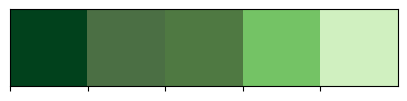

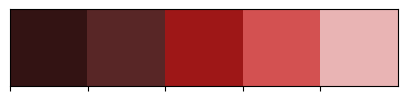

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image


# **Experiments **



## **Steps**
1. Crop brain contunour
2. Split the dataset into train and test folder in 80:20 ratio
3. Generate augmented images for each class in train folder only
4. class folder name in both folder i.e. train and test should be glioma, meningioma, pituitary tumor


In [ ]:
labels = ['glioma','meningioma','pituitary tumor']

In [ ]:

X_train = []
y_train = []
X_test = []
y_test = []

print("Train Set")
print("===========")
image_size = 240
for i in labels:
  # path to the train folder
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Augmented+Split','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
##'/content/Augmented + Split'
print("Test Set")
print("=========")
for i in labels:
  # path to the test folder
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Cropped2','val',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)


"""
import os
import cv2
import numpy as np
from tqdm import tqdm
import imutils  # <-- Added import for imutils

# Initialize lists
X_train = []
y_train = []
X_test = []
y_test = []

image_size = 240

# Function crop_brain_contour should be defined somewhere above
# Make sure it uses imutils.grab_contours correctly

print("Train Set")
print("===========")
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Augmented+Split', 'train', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Unable to read {img_path}")
            continue

        # Apply cropping
        img = crop_brain_contour(img)

        # Resize
        img = cv2.resize(img, (image_size, image_size))

        # Convert grayscale image back to 3 channels
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        X_train.append(img)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Test Set")
print("=========")
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorProject/Cropped2', 'val', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Unable to read {img_path}")
            continue

        # Apply cropping
        img = crop_brain_contour(img)

        # Resize
        img = cv2.resize(img, (image_size, image_size))

        # Convert grayscale image back to 3 channels
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        X_test.append(img)
        y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Data loading complete!")
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")"""


Train Set


100%|██████████| 4215/4215 [01:45<00:00, 39.89it/s] 


Test Set


100%|██████████| 352/352 [00:08<00:00, 39.61it/s] 


'\nimport os\nimport cv2\nimport numpy as np\nfrom tqdm import tqdm\nimport imutils  # <-- Added import for imutils\n\n# Initialize lists\nX_train = []\ny_train = []\nX_test = []\ny_test = []\n\nimage_size = 240\n\n# Function crop_brain_contour should be defined somewhere above\n# Make sure it uses imutils.grab_contours correctly\n\nprint("Train Set")\nprint("===========")\nfor label in labels:\n    folderPath = os.path.join(\'/content/drive/MyDrive/BrainTumorProject/Augmented+Split\', \'train\', label)\n    for filename in tqdm(os.listdir(folderPath)):\n        img_path = os.path.join(folderPath, filename)\n        img = cv2.imread(img_path)\n\n        if img is None:\n            print(f"Warning: Unable to read {img_path}")\n            continue\n\n        # Apply cropping\n        img = crop_brain_contour(img)\n\n        # Resize\n        img = cv2.resize(img, (image_size, image_size))\n\n        # Convert grayscale image back to 3 channels\n        if len(img.shape) == 2:\n        

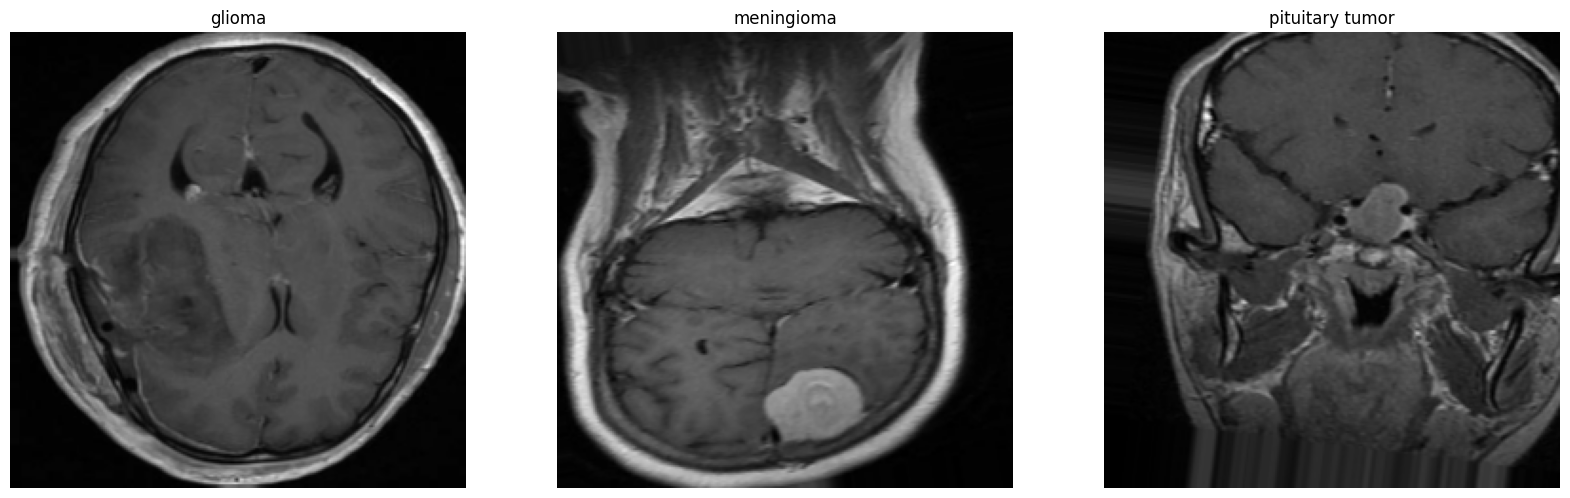

In [ ]:
# plot samples
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
# dataset shuffling
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_test, y_test = shuffle(X_test,y_test, random_state=101)

In [ ]:
X_train.shape

(12362, 240, 240, 3)

In [ ]:
print("x train=",X_train.shape)
print("y train=",y_train.shape)

print("x test=",X_test.shape)
print("y test=",y_test.shape)


x train= (12362, 240, 240, 3)
y train= (12362,)
x test= (1032, 240, 240, 3)
y test= (1032,)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: xlabel='count'>

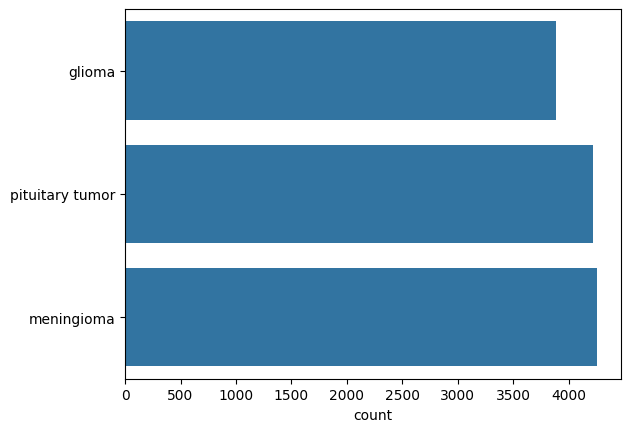

In [ ]:
sns.countplot(y_train)

<Axes: xlabel='count'>

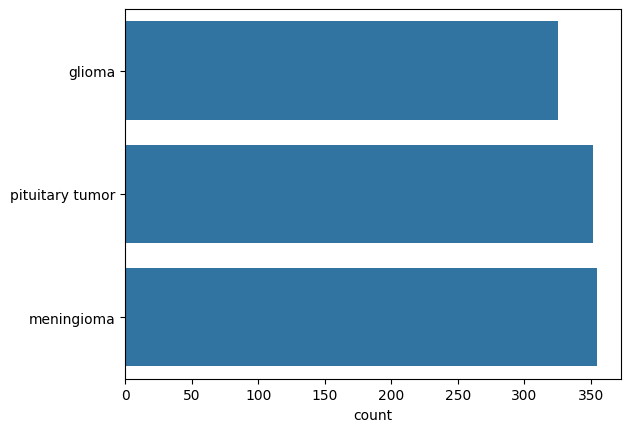

In [ ]:
sns.countplot(y_test)

In [ ]:
# label encoding

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **Experiment **: TL of EfficientNetB2 with label smoothing

### **Transfer Learning**

In [ ]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
## to be removed
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
1 250


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 7,772,796 (29.65 MB)

 Trainable params: 7,705,221 (29.39 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

### **Training The Model**

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6469 - loss: 0.8409
Epoch 1: val_accuracy improved from -inf to 0.85691, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 280s 462ms/step - accuracy: 0.6473 - loss: 0.8404 - val_accuracy: 0.8569 - val_loss: 0.6209 - learning_rate: 3.0000e-05
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9257 - loss: 0.4512
Epoch 2: val_accuracy improved from 0.85691 to 0.94341, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.9257 - loss: 0.4512 - val_accuracy: 0.9434 - val_loss: 0.4082 - learning_rate: 3.0000e-05
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9596 - loss: 0.3913
Epoch 3: val_accuracy improved from 0.94341 to 0.98302, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.9596 - loss: 0.3913 - val_accuracy: 0.9830 - val_loss: 0.3526 - learning_rate: 3.0000e-05
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9760 - loss: 0.3638
Epoch 4: val_accuracy improved from 0.98302 to 0.98949, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.9760 - loss: 0.3638 - val_accuracy: 0.9895 - val_loss: 0.3300 - learning_rate: 3.0000e-05
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9826 - loss: 0.3489
Epoch 5: val_accuracy improved from 0.98949 to 0.99192, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.9826 - loss: 0.3489 - val_accuracy: 0.9919 - val_loss: 0.3211 - learning_rate: 3.0000e-05
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9906 - loss: 0.3348
Epoch 6: val_accuracy improved from 0.99192 to 0.99272, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9906 - loss: 0.3348 - val_accuracy: 0.9927 - val_loss: 0.3155 - learning_rate: 3.0000e-05
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9933 - loss: 0.3270
Epoch 7: val_accuracy improved from 0.99272 to 0.99838, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2WithLabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 79s 226ms/step - accuracy: 0.9933 - loss: 0.3269 - val_accuracy: 0.9984 - val_loss: 0.3087 - learning_rate: 3.0000e-05
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9948 - loss: 0.3226
Epoch 8: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 218ms/step - accuracy: 0.9948 - loss: 0.3226 - val_accuracy: 0.9968 - val_loss: 0.3067 - learning_rate: 3.0000e-05
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9963 - loss: 0.3179
Epoch 9: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy: 0.9963 - loss: 0.3179 - val_accuracy: 0.9984 - val_loss: 0.3049 - learning_rate: 3.0000e-05
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9965 - loss: 0.3140
Epoch 10: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 218ms/step - accuracy: 0.9965 - loss: 0.3140 - val_accuracy: 0.9968 - val_loss: 0.3044 - learning_rate: 

348/348 ━━━━━━━━━━━━━━━━━━━━ 83s 240ms/step - accuracy: 0.9969 - loss: 0.3100 - val_accuracy: 0.9992 - val_loss: 0.3001 - learning_rate: 3.0000e-05
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9985 - loss: 0.3075
Epoch 12: val_accuracy did not improve from 0.99919

Epoch 12: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy: 0.9985 - loss: 0.3075 - val_accuracy: 0.9992 - val_loss: 0.2997 - learning_rate: 3.0000e-05
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9995 - loss: 0.3047
Epoch 13: val_accuracy did not improve from 0.99919
348/348 ━━━━━━━━━━━━━━━━━━━━ 75s 216ms/step - accuracy: 0.9995 - loss: 0.3047 - val_accuracy: 0.9976 - val_loss: 0.2994 - learning_rate: 9.0000e-06
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9994 - loss: 0.3051
Epoch 14: val_accuracy did not improve from 0.99919
348/348 ━━━━━━━━━━━━━━━━━━━━ 76s 217ms/step - accuracy:

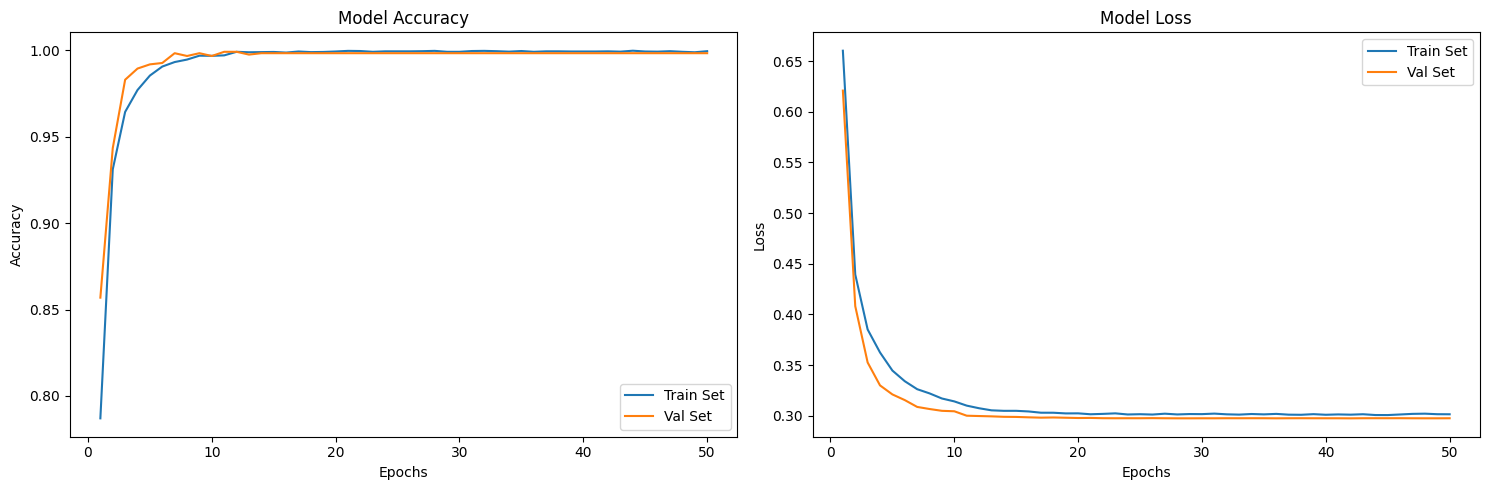

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 302ms/step


In [ ]:
loss,acc = model.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9916 - loss: 0.3079
Test Accuracy:  98.74


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

                 precision    recall  f1-score   support

         glioma     0.9969    0.9846    0.9907       325
     meningioma     0.9804    0.9859    0.9831       355
pituitary tumor     0.9859    0.9915    0.9887       352

       accuracy                         0.9874      1032
      macro avg     0.9877    0.9873    0.9875      1032
   weighted avg     0.9875    0.9874    0.9874      1032



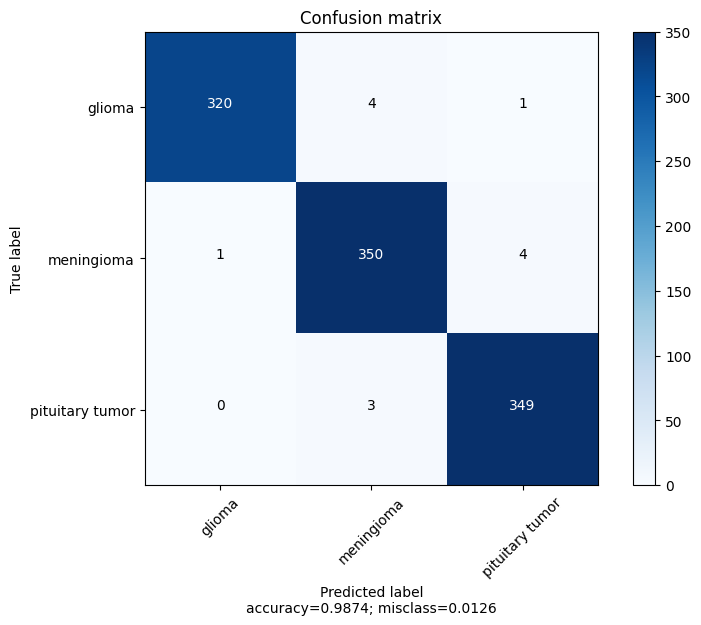

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

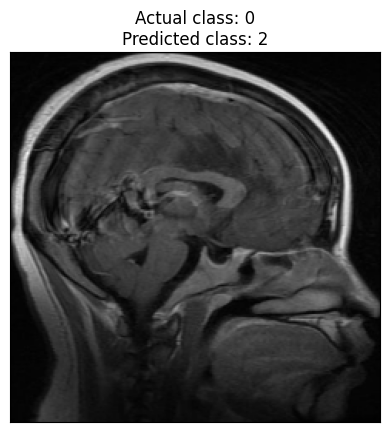

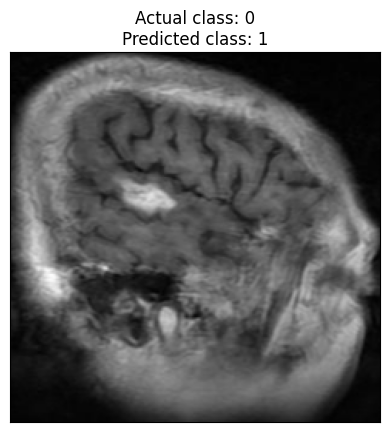

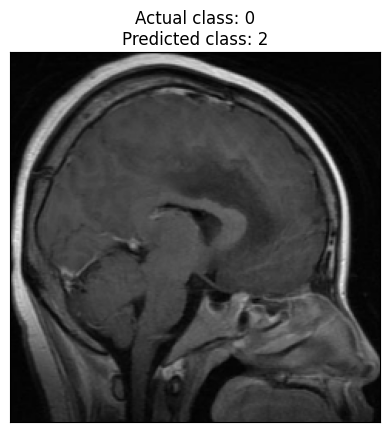

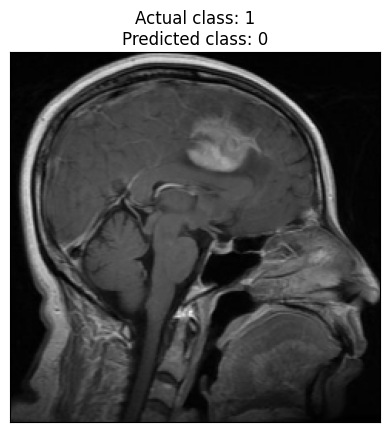

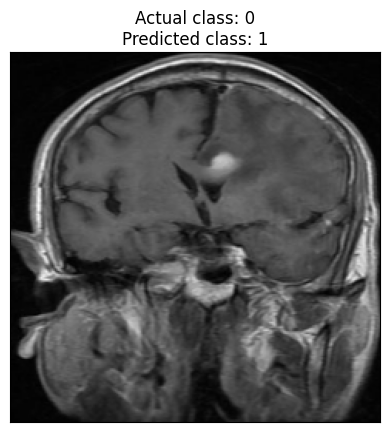

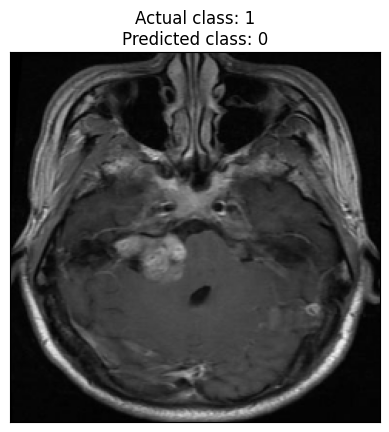

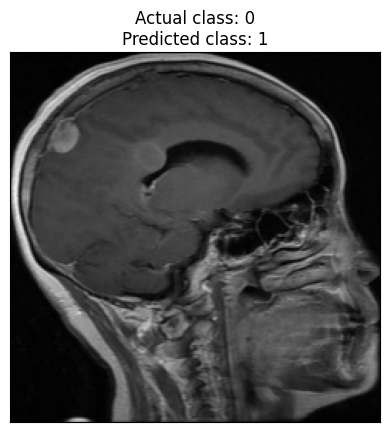

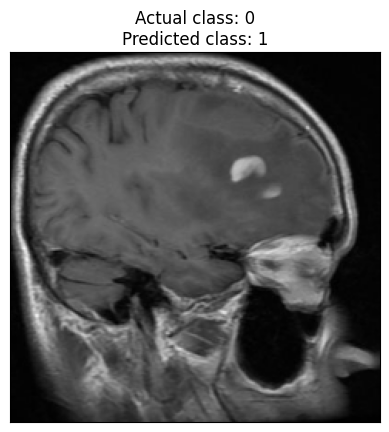

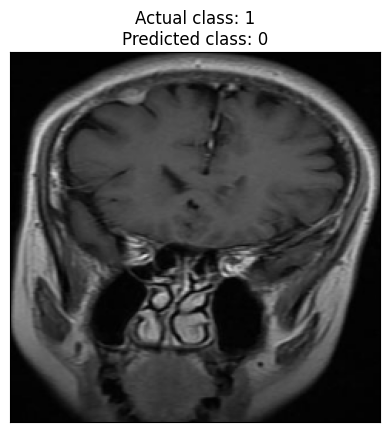

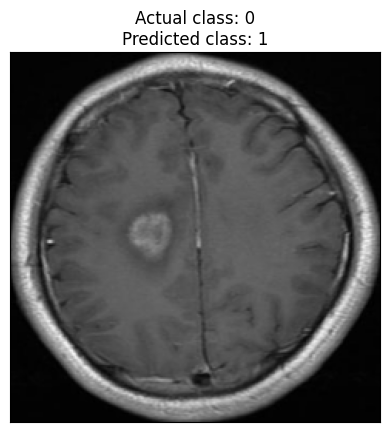

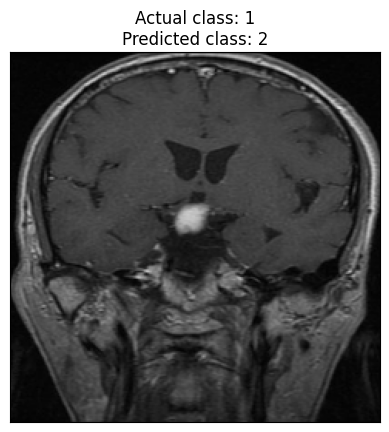

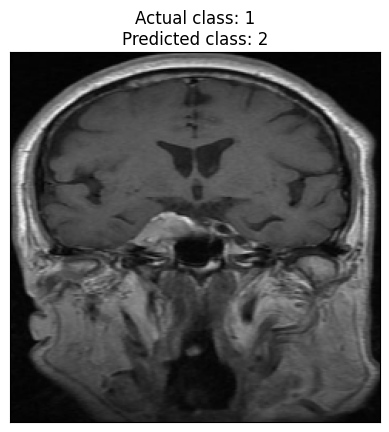

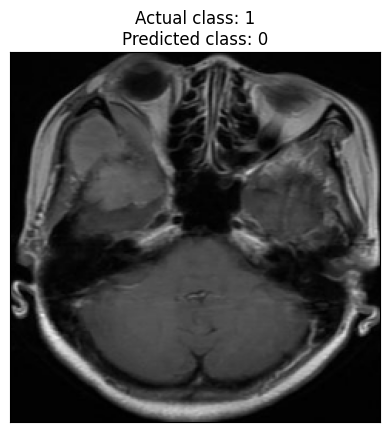

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

Experment hybired with label smothing:

In [ ]:
effnetry2 = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
def transformer_encoder(x, num_heads=2, key_dim=16, ff_dim=64):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)
    return x

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_len=1000, embed_dim=256):
        super().__init__()
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.pos_embedding = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(seq_len)
        pos_embed = self.pos_embedding(positions)
        return x + pos_embed

In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf


x = effnetry2.output
x = layers.Conv2D(256, 1)(x)
x = layers.Reshape((-1, 256))(x)


x = PositionalEmbedding(max_len=1000, embed_dim=256)(x)


x = transformer_encoder(x, num_heads=2, key_dim=16, ff_dim=64)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(3, activation='softmax')(x)

modeltry2 = Model(inputs=effnetry2.input, outputs=output)

In [ ]:
modeltry2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 8,453,276 (32.25 MB)

 Trainable params: 8,385,701 (31.99 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
modeltry2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    metrics=['accuracy']
)



In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = modeltry2.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)

Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7215 - loss: 0.7514
Epoch 1: val_accuracy improved from -inf to 0.79709, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 298s 475ms/step - accuracy: 0.7218 - loss: 0.7510 - val_accuracy: 0.7971 - val_loss: 0.6578 - learning_rate: 3.0000e-05
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9284 - loss: 0.4470
Epoch 2: val_accuracy improved from 0.79709 to 0.94179, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.9284 - loss: 0.4470 - val_accuracy: 0.9418 - val_loss: 0.4253 - learning_rate: 3.0000e-05
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9671 - loss: 0.3946
Epoch 3: val_accuracy improved from 0.94179 to 0.98141, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.9671 - loss: 0.3946 - val_accuracy: 0.9814 - val_loss: 0.3590 - learning_rate: 3.0000e-05
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9809 - loss: 0.3684
Epoch 4: val_accuracy improved from 0.98141 to 0.98626, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.9809 - loss: 0.3684 - val_accuracy: 0.9863 - val_loss: 0.3421 - learning_rate: 3.0000e-05
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9874 - loss: 0.3517
Epoch 5: val_accuracy improved from 0.98626 to 0.99111, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9874 - loss: 0.3517 - val_accuracy: 0.9911 - val_loss: 0.3306 - learning_rate: 3.0000e-05
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9924 - loss: 0.3437
Epoch 6: val_accuracy improved from 0.99111 to 0.99272, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.9924 - loss: 0.3437 - val_accuracy: 0.9927 - val_loss: 0.3278 - learning_rate: 3.0000e-05
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9940 - loss: 0.3350
Epoch 7: val_accuracy improved from 0.99272 to 0.99515, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9940 - loss: 0.3350 - val_accuracy: 0.9951 - val_loss: 0.3207 - learning_rate: 3.0000e-05
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9960 - loss: 0.3279
Epoch 8: val_accuracy improved from 0.99515 to 0.99757, saving model to /content/drive/MyDrive/BrainTumorProject/saved_models/effnetb2v2HypEFFWithlabel.h5


348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.9960 - loss: 0.3279 - val_accuracy: 0.9976 - val_loss: 0.3162 - learning_rate: 3.0000e-05
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9977 - loss: 0.3228
Epoch 9: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.9977 - loss: 0.3228 - val_accuracy: 0.9976 - val_loss: 0.3133 - learning_rate: 3.0000e-05
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9983 - loss: 0.3185
Epoch 10: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.9983 - loss: 0.3185 - val_accuracy: 0.9968 - val_loss: 0.3125 - learning_rate: 3.0000e-05
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9989 - loss: 0.3151
Epoch 11: val_accuracy did not improve from 0.99757
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.9989 - loss: 0.3151 - val_accuracy: 0.9976 - val_loss: 0.3082 - learning_rate

348/348 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.9988 - loss: 0.3132 - val_accuracy: 0.9984 - val_loss: 0.3084 - learning_rate: 3.0000e-05
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9997 - loss: 0.3099
Epoch 13: val_accuracy did not improve from 0.99838

Epoch 13: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9997 - loss: 0.3099 - val_accuracy: 0.9976 - val_loss: 0.3050 - learning_rate: 3.0000e-05
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9992 - loss: 0.3083
Epoch 14: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy: 0.9992 - loss: 0.3083 - val_accuracy: 0.9976 - val_loss: 0.3038 - learning_rate: 9.0000e-06
Epoch 15/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9996 - loss: 0.3070
Epoch 15: val_accuracy did not improve from 0.99838
348/348 ━━━━━━━━━━━━━━━━━━━━ 77s 223ms/step - accuracy:

348/348 ━━━━━━━━━━━━━━━━━━━━ 84s 243ms/step - accuracy: 0.9998 - loss: 0.3052 - val_accuracy: 0.9992 - val_loss: 0.3012 - learning_rate: 9.0000e-06
Epoch 18/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9995 - loss: 0.3049
Epoch 18: val_accuracy did not improve from 0.99919
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9995 - loss: 0.3049 - val_accuracy: 0.9984 - val_loss: 0.3017 - learning_rate: 9.0000e-06
Epoch 19/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9999 - loss: 0.3035
Epoch 19: val_accuracy did not improve from 0.99919
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9999 - loss: 0.3035 - val_accuracy: 0.9984 - val_loss: 0.3011 - learning_rate: 9.0000e-06
Epoch 20/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9996 - loss: 0.3035
Epoch 20: val_accuracy did not improve from 0.99919
348/348 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.9996 - loss: 0.3035 - val_accuracy: 0.9992 - val_loss: 0.3009 - learning_ra

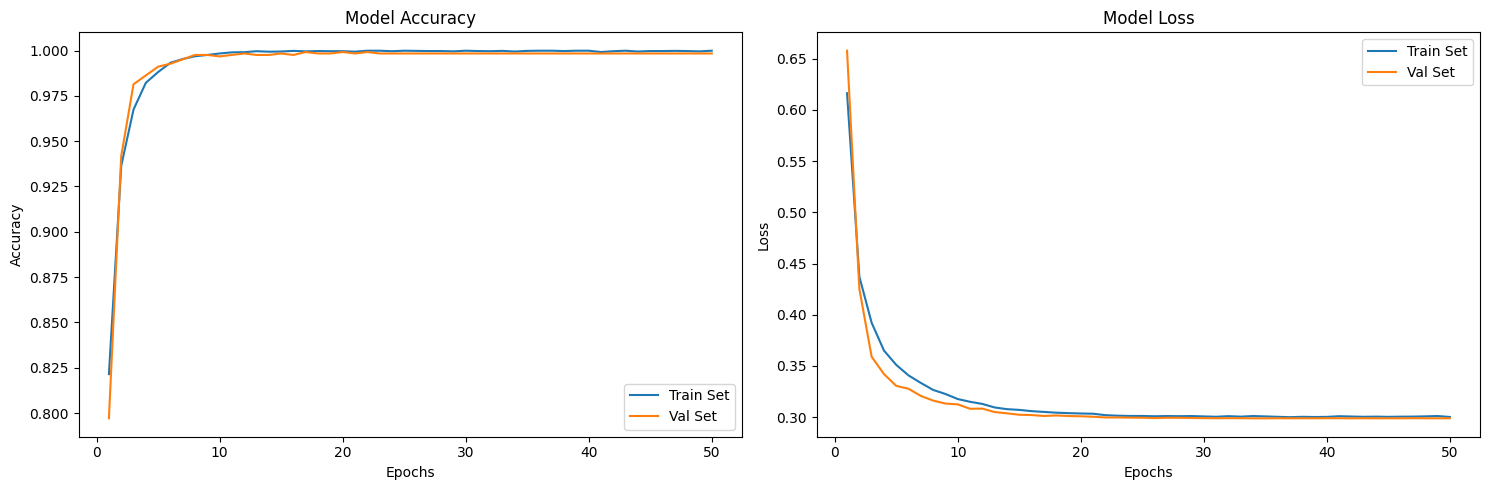

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
pred = modeltry2.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)


33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 613ms/step


In [ ]:
loss,acc = modeltry2.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.9907 - loss: 0.3148
Test Accuracy:  98.55


In [ ]:
print(classification_report(y_test_new,pred,target_names = labels,digits = 4))

                 precision    recall  f1-score   support

         glioma     0.9816    0.9846    0.9831       325
     meningioma     0.9830    0.9775    0.9802       355
pituitary tumor     0.9915    0.9943    0.9929       352

       accuracy                         0.9855      1032
      macro avg     0.9854    0.9855    0.9854      1032
   weighted avg     0.9855    0.9855    0.9855      1032



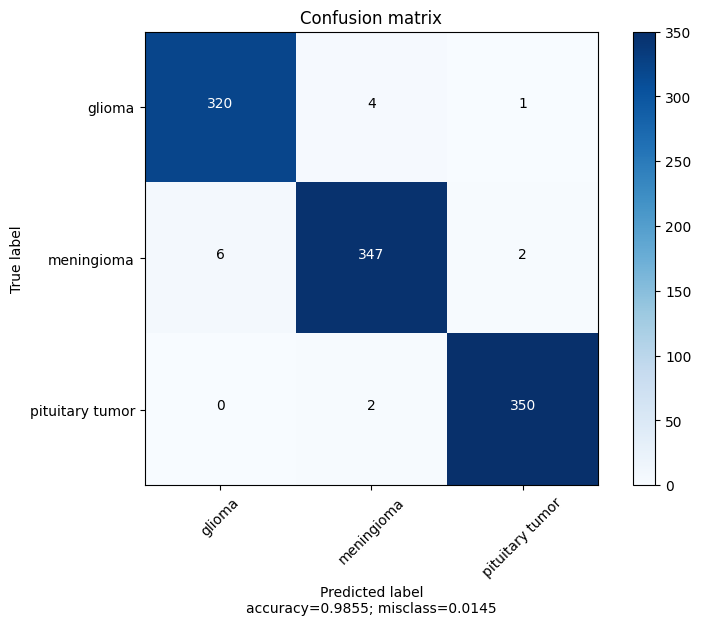

In [ ]:
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names = labels, normalize=False)

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()